# How to request and plot histograms
For every state and extraction time point the MC engine computes _mean_, _stddev_ and _skewness_ values of

In [1]:
from init import *

## Defining the model
### Two correlated Brownian motion processes

The very first state function (with number=0) is resposible for generation of independent gaussian variables.
The second state function (with number=0) will generate a correlated gaussian varible. 
The next two states will are two brownian motion processes:

\begin{eqnarray}
W_0 &\sim& N(0,1)
\\
W_1 &\sim& N(0,1)
\\
\text{d}S_2 &=& \mu_1\text{d}t + \sigma_1 \text{d}W_0
\\
\text{d}S_3 &=& \mu_2\text{d}t + \sigma_2 \text{d}W_1
\end{eqnarray}

with 

\begin{eqnarray}
[\text{d}W_1,\text{d}W_2] = \rho \text{d}t
\end{eqnarray}


In [2]:
W1_state_number = 2
W2_state_number = 3

def model_correlated_bm ():
    model = sdk.Model()
    model.TimeStart = 0
    model.TimeSteps = 1000
    model.NumPaths = 100000
    correlation = 0.25

    model.Add(sdk.IndependentGaussian([W1_state_number]))._state
    model.Add(sdk.CorrelatedGaussian(correlation,W1_state_number,W2_state_number))

    W1 = model.Add(sdk.BrownianMotion(start=0,drift=0.2,diffusion=0.7,title='BrownianMotion: W1'))
    assert W1.GetStateNumber()==W1_state_number

    W2 = model.Add(sdk.BrownianMotion(start=1,drift=-0.3,diffusion=0.5,title='BrownianMotion: W2'))
    assert W2.GetStateNumber()==W2_state_number
    return model

## Adding extraction points
Our BM processes will start at $t=0$, and lets say we want to extract results three time points: $1,2,5$.
### ... without histogram request


In [3]:
model = model_correlated_bm()
for t in [1,2,5]:
    model.evaluations.append(sdk.EvaluationPoint(t))
results = sdk.run (model, server)
results.df()

,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,BrownianMotion: W1,2,1.0,199,100000,0.202385,0.002207,0.697961,0.000175
1,BrownianMotion,BrownianMotion: W2,3,1.0,199,100000,0.697680,0.001576,0.498248,0.006858
2,BrownianMotion,BrownianMotion: W1,2,2.0,399,100000,0.407178,0.003113,0.984264,0.003991
3,BrownianMotion,BrownianMotion: W2,3,2.0,399,100000,0.398210,0.002233,0.706201,0.002213
4,BrownianMotion,BrownianMotion: W1,2,5.0,999,100000,1.006938,0.004916,1.554606,-0.005721
5,BrownianMotion,BrownianMotion: W2,3,5.0,999,100000,-0.507569,0.003532,1.116902,0.003832


There are no histograms in the _results_ object:

In [4]:
len(results.histograms)

0

### ... adding 1D histogram
We need to attach a histogram request to evaluation points. A histogram defintion requires one (for 1d-histogram)  or two (2d-histogram) axis definitions. To define an axis we need to know:

- a state number from which data will be taken during histogram fill process
- number of bins to be used for filling
- [optional] (min,max) axis range. 

If $(min,max)$ is not provided, or the range is badly defined (the values must be finite and $min<max$), the MC engine will determine the range itself, using _mean,stddev_ and _skewness_ parameters of a state distribution.

In [5]:
model = model_correlated_bm()
for t in [1,2,5]:
    model.evaluations.append(
        sdk.EvaluationPoint(t)
            .Add(sdk.Histogram(
                # for W1 histogram we request the engine to compute the range
                ax = sdk.HistogramAxis(state=W1_state_number,nbins=100),
            ))
            .Add(sdk.Histogram(
                # for W2 histogram we provide the range (min,max)
                ax = sdk.HistogramAxis(state=W2_state_number,nbins=100,min=-5,max=5),
            ))
    )
results = sdk.run (model, server)
results.df()

,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,BrownianMotion: W1,2,1.0,199,100000,0.202385,0.002207,0.697961,0.000175
1,BrownianMotion,BrownianMotion: W2,3,1.0,199,100000,0.697680,0.001576,0.498248,0.006858
2,BrownianMotion,BrownianMotion: W1,2,2.0,399,100000,0.407178,0.003113,0.984264,0.003991
3,BrownianMotion,BrownianMotion: W2,3,2.0,399,100000,0.398210,0.002233,0.706201,0.002213
4,BrownianMotion,BrownianMotion: W1,2,5.0,999,100000,1.006938,0.004916,1.554606,-0.005721
5,BrownianMotion,BrownianMotion: W2,3,5.0,999,100000,-0.507569,0.003532,1.116902,0.003832


We requested two histograms for each of the three extraction points:

In [6]:
len(results.histograms)

6

### ... adding 2D histogram

To define a 2D histogram we need to pass one more axis definition:

In [7]:
model = model_correlated_bm()
for t in [1,2,5]:
    model.evaluations.append(
        sdk.EvaluationPoint(t)
            .Add(sdk.Histogram(
                # for W1 histogram we request the engine to compute the range
                ax = sdk.HistogramAxis(state=W1_state_number,nbins=100),
            ))
            .Add(sdk.Histogram(
                # for W2 histogram we provide the range (min,max)
                ax = sdk.HistogramAxis(state=W2_state_number,nbins=100,min=-5,max=5),
            ))
            .Add(sdk.Histogram(
                ax = sdk.HistogramAxis(W1_state_number,nbins=100),
                ay = sdk.HistogramAxis(W2_state_number,nbins=100,min=-5,max=5)
            ))
    )
results = sdk.run (model, server)
results.df()

,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,BrownianMotion: W1,2,1.0,199,100000,0.202385,0.002207,0.697961,0.000175
1,BrownianMotion,BrownianMotion: W2,3,1.0,199,100000,0.697680,0.001576,0.498248,0.006858
2,BrownianMotion,BrownianMotion: W1,2,2.0,399,100000,0.407178,0.003113,0.984264,0.003991
3,BrownianMotion,BrownianMotion: W2,3,2.0,399,100000,0.398210,0.002233,0.706201,0.002213
4,BrownianMotion,BrownianMotion: W1,2,5.0,999,100000,1.006938,0.004916,1.554606,-0.005721
5,BrownianMotion,BrownianMotion: W2,3,5.0,999,100000,-0.507569,0.003532,1.116902,0.003832


### Notes
- You can add histogram filling request only to some of evaluation points.
- For the same evaluation point and the same state (or states for 2dhist), several histogram request can be made (with different binning and/or axis range).
- Histograms objects can be big, be carefull with bin sizes and the number of requested histograms.

## Plotting histograms
There is a helper function *plot()* to do the job.

## Histograms at extraction point 0

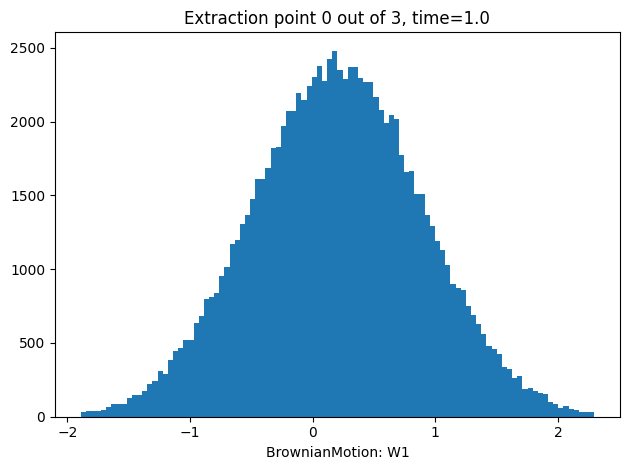

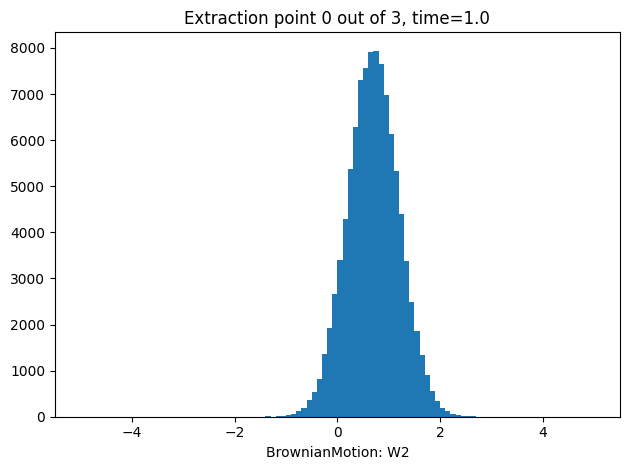

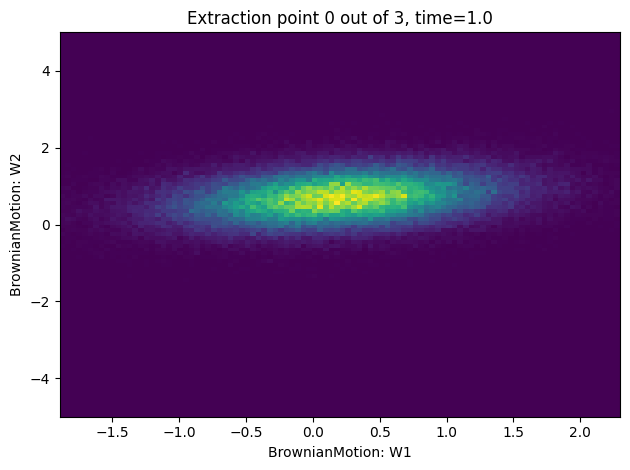

In [8]:
point = 0
plot(results,point,W1_state_number)
plot(results,point,W2_state_number)
plot(results,point,W1_state_number,W2_state_number)

## Histograms at extraction point 1

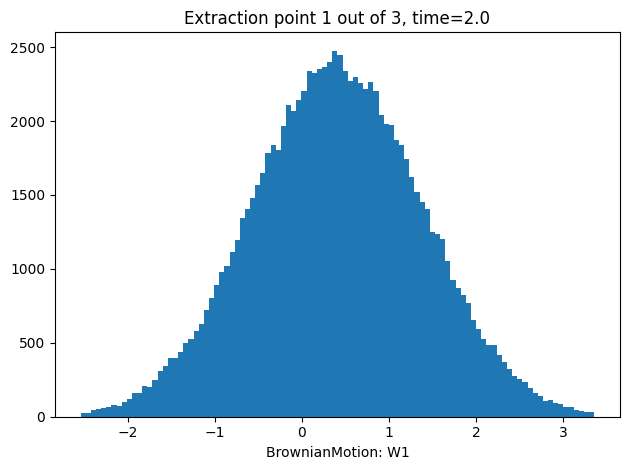

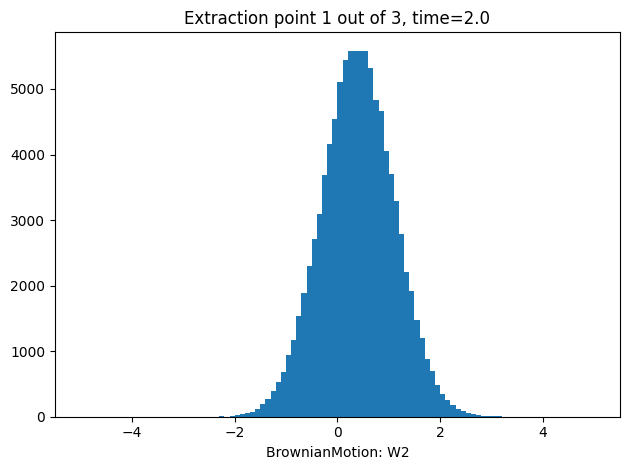

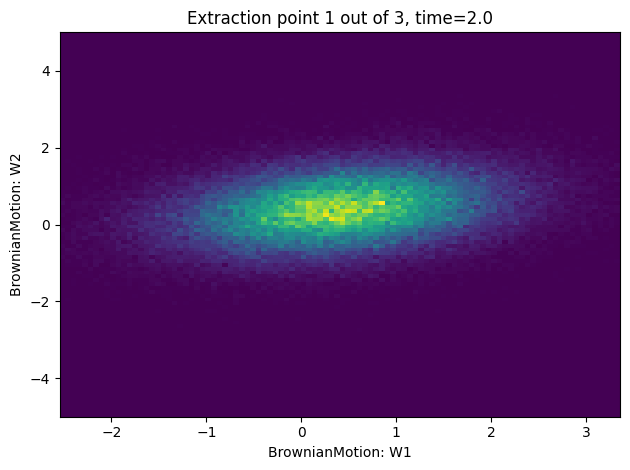

In [9]:
point = 1
plot(results,point,W1_state_number)
plot(results,point,W2_state_number)
plot(results,point,W1_state_number,W2_state_number)

## Histograms at extraction point 2

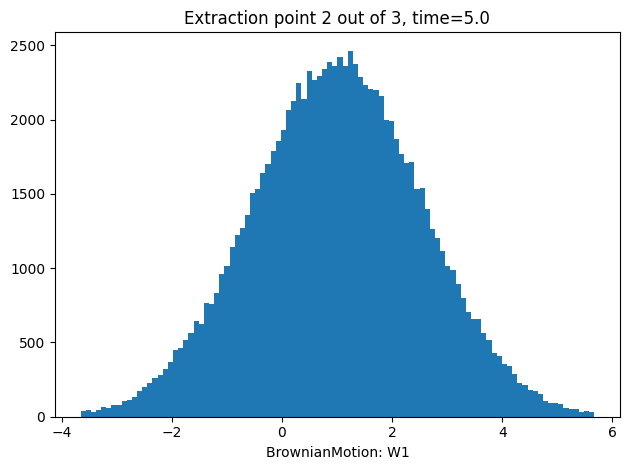

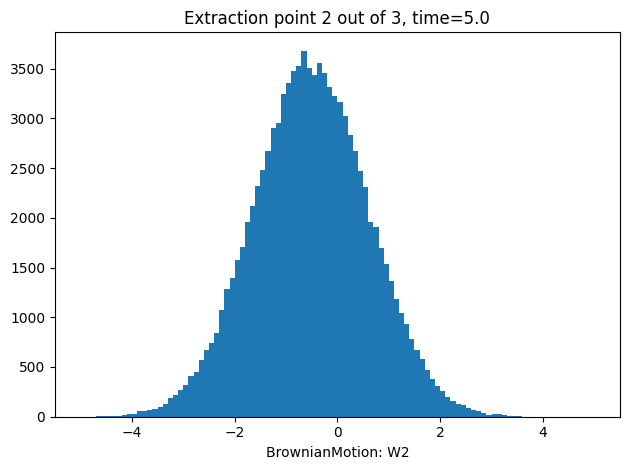

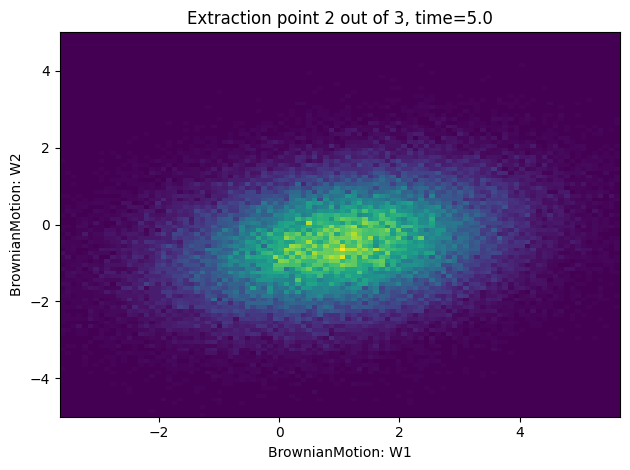

In [10]:
point = 2
plot(results,point,W1_state_number)
plot(results,point,W2_state_number)
plot(results,point,W1_state_number,W2_state_number)